### 📚Import Libraries

In [1]:
# Standard library imports
import os
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os.path as osp
import csv
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import pandas as pd

### 🔧 Utility Function

In [2]:
def get_device_info():
    """
    Returns the best available device (CUDA-enabled GPU if possible, otherwise CPU)
    and prints detailed information.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"✅ GPU available: {gpu_name} ({gpu_memory:.2f} GB)")
    else:
        device = torch.device("cpu")
        print("❌ No GPU available, using CPU.")

    return device

# Get the best available device
device = get_device_info()

✅ GPU available: Tesla T4 (15.83 GB)


### 📂 Data Preparation

In [3]:
%%capture
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root: str, test: bool = False, transform=None):
        super().__init__()
        self.root = root
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
        ])
        self.test = test

        self.img_path = osp.join(root, 'images')
        self.targets = []
        self.ids = []

        if not test:
            # Load images and labels
            labels_path = osp.join(root, 'labels.csv')
            with open(labels_path, 'r') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    image_id = row['id'].zfill(5)
                    label = int(row['label'])
                    self.targets.append(label)
                    self.ids.append(image_id)
        else:
            # Test mode: no labels.csv
            for fname in sorted(os.listdir(self.img_path)):
                if fname.endswith('.jpeg'):
                    image_id = fname[:-5].zfill(5)
                    self.ids.append(image_id)

    def __getitem__(self, index: int):
        img_id = self.ids[index]
        img_file = osp.join(self.img_path, f'{img_id}.jpeg')
        img = Image.open(img_file).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        if self.test:
            return img, img_id
        else:
            target = self.targets[index]
            return img, target

    def __len__(self) -> int:
        return len(self.ids)

In [5]:
datasets_dir = '/kaggle/input/unipd-deep-learning-2025-challenge-1'

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5132, 0.4647, 0.4044],   
                        std=[0.2626, 0.2559, 0.2748])
])

# create datasets
train_dataset = ImageDataset(osp.join(datasets_dir, 'train_dataset'), test=False)
test_dataset = ImageDataset(osp.join(datasets_dir, 'test_dataset'), test=True, transform=test_transform)

# Print sizes
print(f"Training subset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training subset size: 22430
Test dataset size: 4000


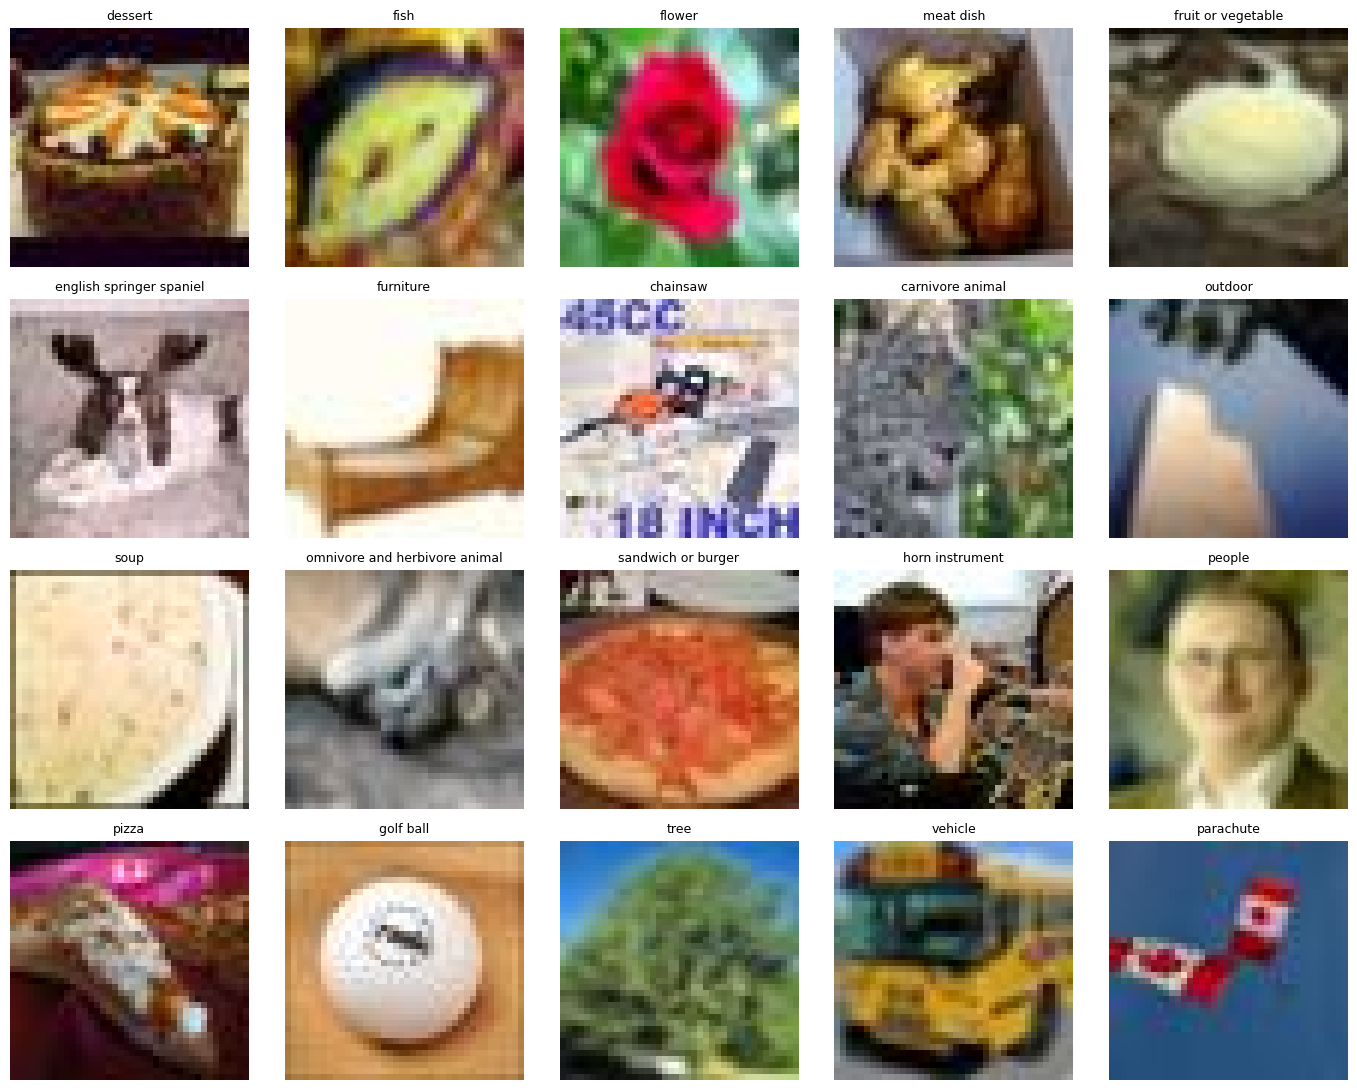

In [6]:
import matplotlib.pyplot as plt

# ------------ 1. classi (nell’ordine del label) ------------
class_names = [
    "dessert", "fish", "flower", "meat dish", "fruit or vegetable",
    "english springer spaniel", "furniture", "chainsaw", "carnivore animal",
    "outdoor", "soup", "omnivore and herbivore animal", "sandwich or burger",
    "horn instrument", "people", "pizza", "golf ball", "tree", "vehicle", "parachute"
]

# ------------ 2. prima immagine per classe ------------
samples = {}                      # label ➜ tensor immagine
for img, lbl in train_dataset:     # scorre una sola volta il subset
    lbl_int = int(lbl)
    if lbl_int not in samples:
        samples[lbl_int] = img
    if len(samples) == len(class_names):
        break

imgs = [samples[i] for i in range(len(class_names))]

# ------------ 3. griglia con label ------------
rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(14, 11))

for idx, (ax, img) in enumerate(zip(axes.ravel(), imgs)):
    # Tensor (C,H,W) ➜ NumPy (H,W,C) + normalizzazione 0‑1 per la visualizzazione
    np_img = img.clone().permute(1, 2, 0)
    np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
    ax.imshow(np_img)
    ax.set_title(class_names[idx], fontsize=9)
    ax.axis("off")

plt.tight_layout(w_pad=0.5, h_pad=1.0)
plt.show()

In [7]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    Residual block with anti-aliasing downsampling and optional dilation.
    - If stride > 1: applies AvgPool2d before conv1 (anti-aliasing).
    - Supports dilated conv2 for larger receptive field without extra downsampling.
    """
    def __init__(self, in_channels, out_channels, stride=1, dilation=1, activation=nn.SiLU):
        super().__init__()
        # Anti-aliasing downsample for feature maps and identity
        self.pool = nn.AvgPool2d(kernel_size=stride, stride=stride) if stride > 1 else None

        # Identity downsample if channel or resolution changes
        self.downsample = None
        if stride > 1 or in_channels != out_channels:
            layers = []
            if stride > 1:
                layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride))
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            ])
            self.downsample = nn.Sequential(*layers)

        # First conv: always stride=1, padding=1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act = activation(inplace=True)

        # Second conv: dilated convolution
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1,
            padding=dilation, dilation=dilation,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x
        out = x

        # Anti-aliasing pool before conv1
        if self.pool is not None:
            out = self.pool(out)

        # First conv + BN + activation
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.act(out)

        # Second (dilated) conv + BN
        out = self.conv2(out)
        out = self.bn2(out)

        # Downsample identity if needed
        if self.downsample is not None:
            identity = self.downsample(identity)

        # Residual addition + activation
        out += identity
        out = self.act(out)
        return out


class ImageClassifier(nn.Module):
    def __init__(self, num_classes=20, dropout=0.5, activation=nn.SiLU):
        super().__init__()
        act = lambda: activation(inplace=True)

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            act()
        )

        # Stage 1: keep spatial size (40x40)
        self.res1 = ResidualBlock(64, 64, stride=1, dilation=1, activation=activation)
        self.drop1 = nn.Dropout2d(0.1)

        # Stage 2: downsample to 20x20
        self.res2 = ResidualBlock(64, 128, stride=2, dilation=1, activation=activation)

        # Stage 3: downsample to 10x10, use dilation=2 for conv2
        self.res3 = ResidualBlock(128, 256, stride=2, dilation=2, activation=activation)

        # Stage 4: downsample to 5x5, use dilation=4 for conv2
        self.res4 = ResidualBlock(256, 512, stride=2, dilation=4, activation=activation)

        # Global average pooling + classifier head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.res1(x)
        x = self.drop1(x)

        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)

        x = self.gap(x)
        x = self.classifier(x)
        return x



Trying parameters: {'optimizer': 'sgd', 'learning_rate': 0.005, 'momentum': 0.95, 'weight_decay': 0.0001, 'dropout': 0.1, 'flip_prob': 0.5, 'rotation_degrees': 15, 'brightness': 0.1, 'contrast': 0.1, 'saturation': 0.1}
>>> Fold 1/10
Epoch 1/150 | Train Loss: 1.5722, F1: 0.3491 | Val Loss: 0.5672, F1: 0.4402
Epoch 2/150 | Train Loss: 1.0951, F1: 0.4762 | Val Loss: 0.4582, F1: 0.5362
Epoch 3/150 | Train Loss: 0.9220, F1: 0.5384 | Val Loss: 0.3943, F1: 0.5837
Epoch 4/150 | Train Loss: 0.8018, F1: 0.5858 | Val Loss: 0.3842, F1: 0.5914
Epoch 5/150 | Train Loss: 0.7169, F1: 0.6173 | Val Loss: 0.3313, F1: 0.6420
Epoch 6/150 | Train Loss: 0.6472, F1: 0.6486 | Val Loss: 0.3235, F1: 0.6401
Epoch 7/150 | Train Loss: 0.5972, F1: 0.6682 | Val Loss: 0.2875, F1: 0.6797
Epoch 8/150 | Train Loss: 0.5471, F1: 0.6900 | Val Loss: 0.2941, F1: 0.6734
Epoch 9/150 | Train Loss: 0.5123, F1: 0.7046 | Val Loss: 0.2890, F1: 0.6906
Epoch 10/150 | Train Loss: 0.4774, F1: 0.7201 | Val Loss: 0.2608, F1: 0.7141
Epoch

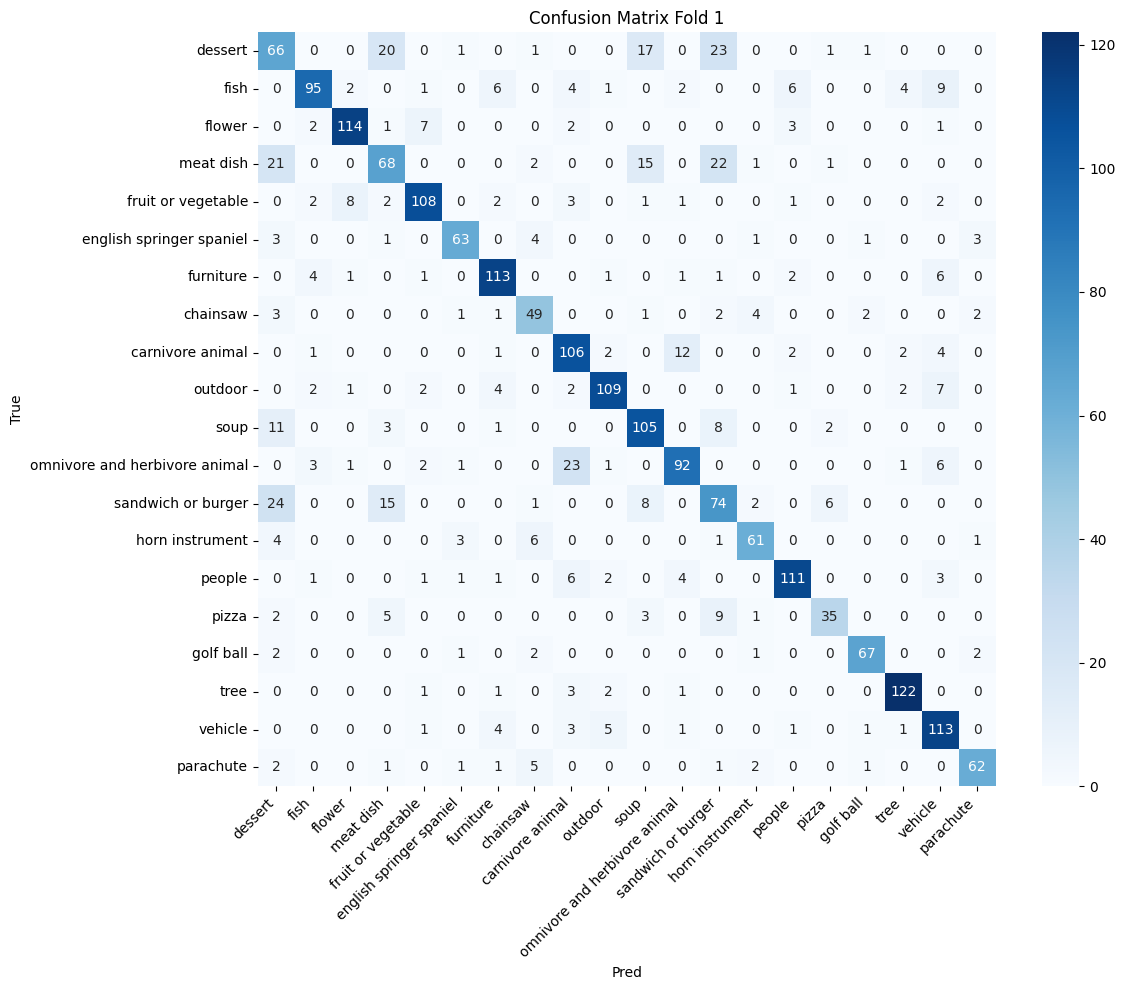

>>> Fold 2/10
Epoch 1/150 | Train Loss: 1.6056, F1: 0.3365 | Val Loss: 0.6205, F1: 0.4134
Epoch 2/150 | Train Loss: 1.1442, F1: 0.4614 | Val Loss: 0.5343, F1: 0.4833
Epoch 3/150 | Train Loss: 0.9473, F1: 0.5276 | Val Loss: 0.4209, F1: 0.5600
Epoch 4/150 | Train Loss: 0.8283, F1: 0.5733 | Val Loss: 0.3831, F1: 0.5896
Epoch 5/150 | Train Loss: 0.7398, F1: 0.6098 | Val Loss: 0.3539, F1: 0.6174
Epoch 6/150 | Train Loss: 0.6679, F1: 0.6366 | Val Loss: 0.3405, F1: 0.6228
Epoch 7/150 | Train Loss: 0.6182, F1: 0.6555 | Val Loss: 0.3116, F1: 0.6439
Epoch 8/150 | Train Loss: 0.5553, F1: 0.6840 | Val Loss: 0.2931, F1: 0.6767
Epoch 9/150 | Train Loss: 0.5249, F1: 0.6998 | Val Loss: 0.2753, F1: 0.6893
Epoch 10/150 | Train Loss: 0.4757, F1: 0.7242 | Val Loss: 0.2588, F1: 0.6900
Epoch 11/150 | Train Loss: 0.4543, F1: 0.7307 | Val Loss: 0.2621, F1: 0.6968
Epoch 12/150 | Train Loss: 0.4143, F1: 0.7474 | Val Loss: 0.2570, F1: 0.6980
Epoch 13/150 | Train Loss: 0.3962, F1: 0.7600 | Val Loss: 0.2424, F1: 0

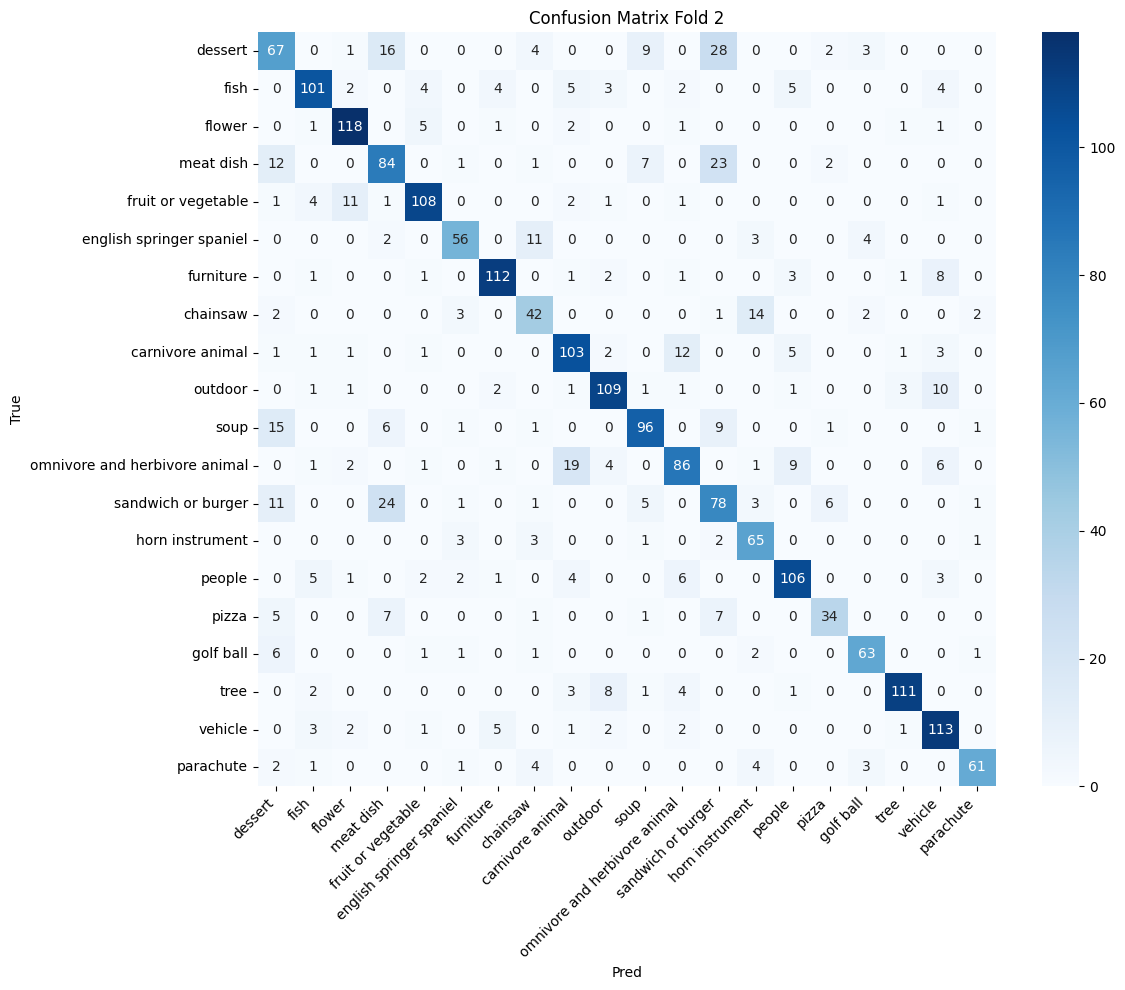

>>> Fold 3/10
Epoch 1/150 | Train Loss: 1.5796, F1: 0.3450 | Val Loss: 0.5714, F1: 0.4624
Epoch 2/150 | Train Loss: 1.0905, F1: 0.4775 | Val Loss: 0.4544, F1: 0.5462
Epoch 3/150 | Train Loss: 0.9063, F1: 0.5421 | Val Loss: 0.4082, F1: 0.5783
Epoch 4/150 | Train Loss: 0.7940, F1: 0.5849 | Val Loss: 0.3568, F1: 0.6202
Epoch 5/150 | Train Loss: 0.7092, F1: 0.6217 | Val Loss: 0.3228, F1: 0.6434
Epoch 6/150 | Train Loss: 0.6456, F1: 0.6470 | Val Loss: 0.3192, F1: 0.6549
Epoch 7/150 | Train Loss: 0.5918, F1: 0.6689 | Val Loss: 0.2843, F1: 0.6776
Epoch 8/150 | Train Loss: 0.5418, F1: 0.6919 | Val Loss: 0.2753, F1: 0.6880
Epoch 9/150 | Train Loss: 0.5087, F1: 0.7066 | Val Loss: 0.2769, F1: 0.6900
Epoch 10/150 | Train Loss: 0.4698, F1: 0.7241 | Val Loss: 0.2811, F1: 0.7036
Epoch 11/150 | Train Loss: 0.4291, F1: 0.7430 | Val Loss: 0.2392, F1: 0.7374
Epoch 12/150 | Train Loss: 0.4132, F1: 0.7515 | Val Loss: 0.2550, F1: 0.7322
Epoch 13/150 | Train Loss: 0.3802, F1: 0.7672 | Val Loss: 0.2484, F1: 0

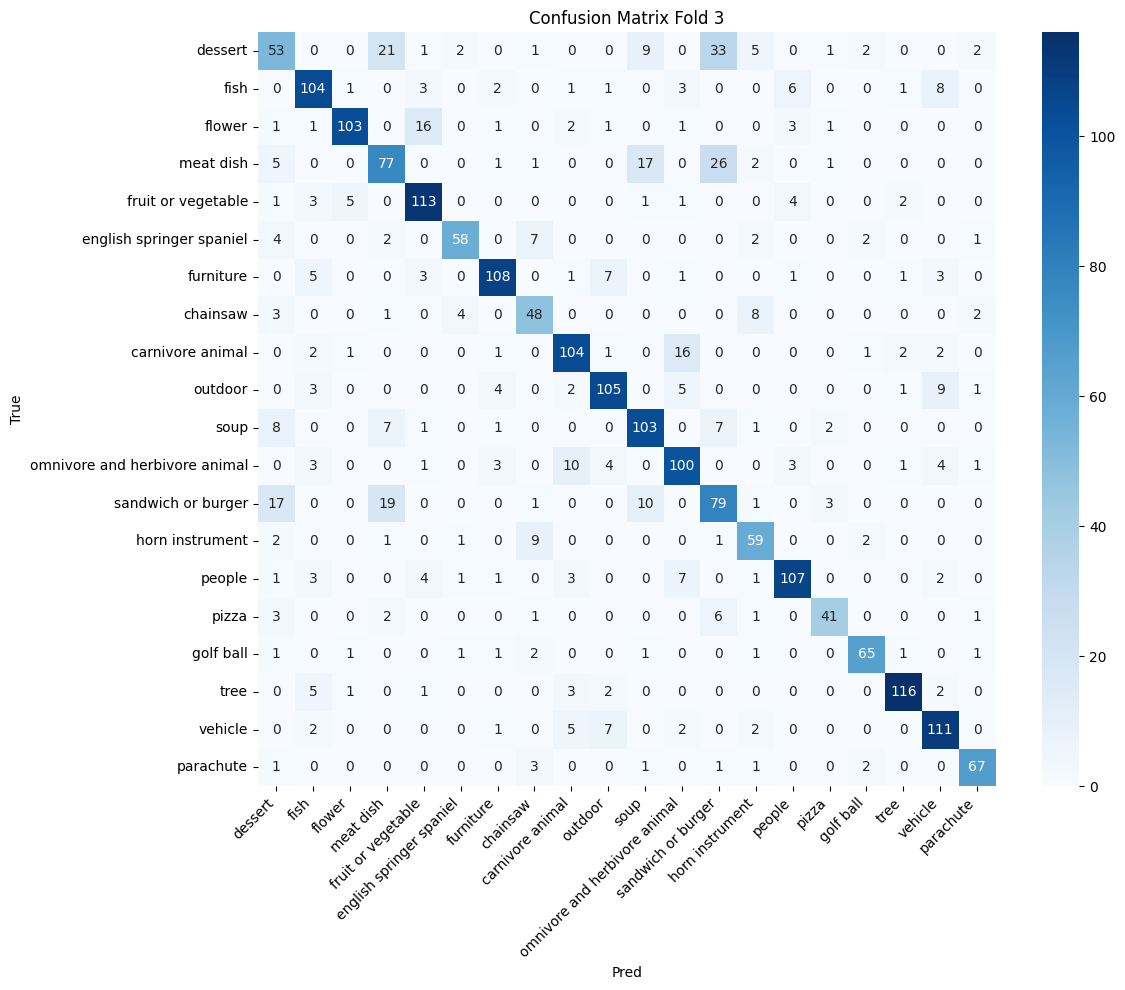

>>> Fold 4/10
Epoch 1/150 | Train Loss: 1.5918, F1: 0.3399 | Val Loss: 0.6010, F1: 0.4410
Epoch 2/150 | Train Loss: 1.1199, F1: 0.4691 | Val Loss: 0.4677, F1: 0.5130
Epoch 3/150 | Train Loss: 0.9452, F1: 0.5325 | Val Loss: 0.3767, F1: 0.5862
Epoch 4/150 | Train Loss: 0.8185, F1: 0.5776 | Val Loss: 0.3570, F1: 0.6008
Epoch 5/150 | Train Loss: 0.7186, F1: 0.6179 | Val Loss: 0.3217, F1: 0.6454
Epoch 6/150 | Train Loss: 0.6699, F1: 0.6404 | Val Loss: 0.3172, F1: 0.6409
Epoch 7/150 | Train Loss: 0.6097, F1: 0.6648 | Val Loss: 0.2858, F1: 0.6736
Epoch 8/150 | Train Loss: 0.5577, F1: 0.6873 | Val Loss: 0.2678, F1: 0.7001
Epoch 9/150 | Train Loss: 0.5104, F1: 0.7047 | Val Loss: 0.2753, F1: 0.6902
Epoch 10/150 | Train Loss: 0.4803, F1: 0.7211 | Val Loss: 0.2510, F1: 0.7005
Epoch 11/150 | Train Loss: 0.4428, F1: 0.7392 | Val Loss: 0.2456, F1: 0.7104
Epoch 12/150 | Train Loss: 0.4237, F1: 0.7467 | Val Loss: 0.2413, F1: 0.7158
Epoch 13/150 | Train Loss: 0.3857, F1: 0.7642 | Val Loss: 0.2417, F1: 0

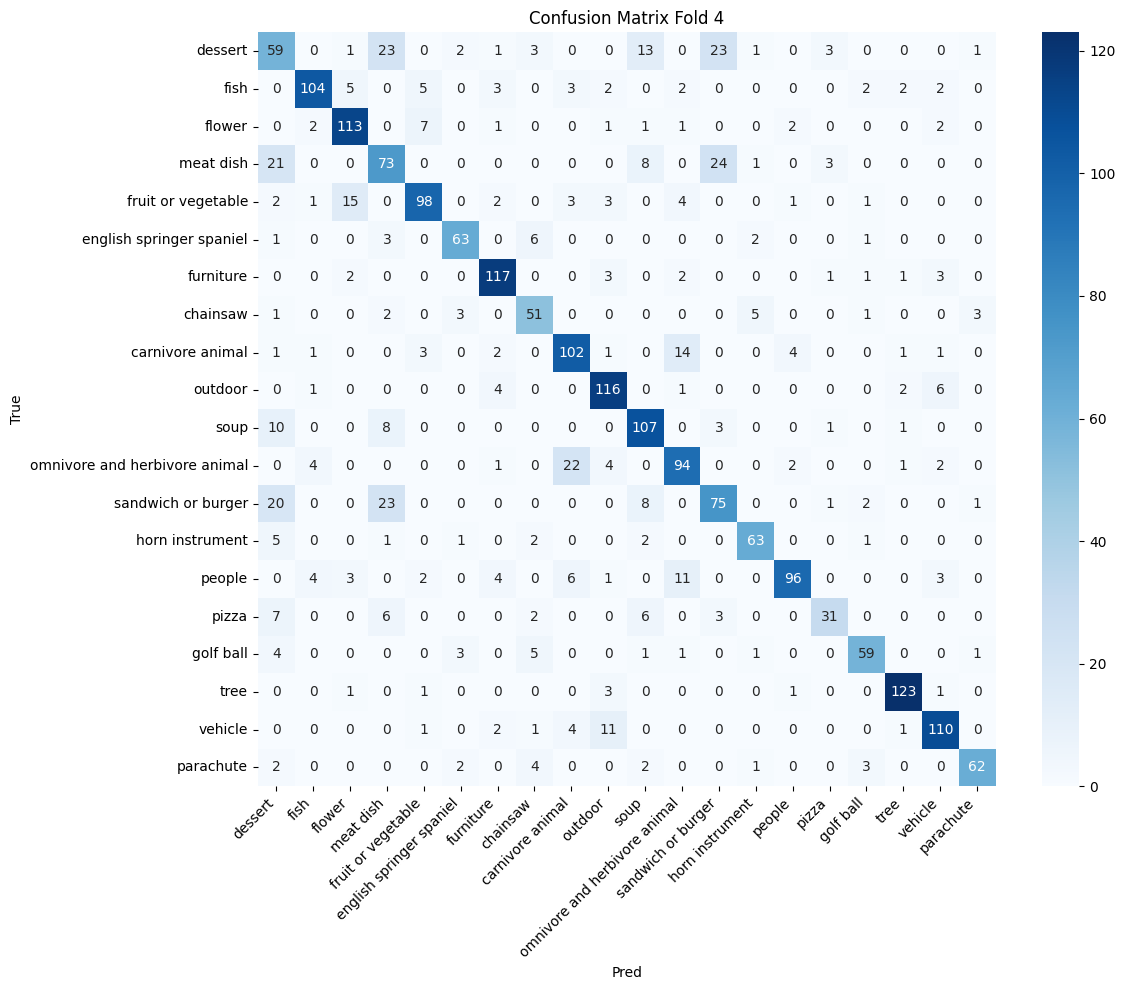

>>> Fold 5/10
Epoch 1/150 | Train Loss: 1.5873, F1: 0.3396 | Val Loss: 0.6182, F1: 0.4135
Epoch 2/150 | Train Loss: 1.1195, F1: 0.4669 | Val Loss: 0.4293, F1: 0.5529
Epoch 3/150 | Train Loss: 0.9197, F1: 0.5370 | Val Loss: 0.3702, F1: 0.6139
Epoch 4/150 | Train Loss: 0.7917, F1: 0.5894 | Val Loss: 0.3705, F1: 0.5933
Epoch 5/150 | Train Loss: 0.7145, F1: 0.6200 | Val Loss: 0.3131, F1: 0.6613
Epoch 6/150 | Train Loss: 0.6417, F1: 0.6508 | Val Loss: 0.3017, F1: 0.6739
Epoch 7/150 | Train Loss: 0.5968, F1: 0.6694 | Val Loss: 0.3139, F1: 0.6689
Epoch 8/150 | Train Loss: 0.5454, F1: 0.6909 | Val Loss: 0.2711, F1: 0.6968
Epoch 9/150 | Train Loss: 0.5099, F1: 0.7026 | Val Loss: 0.2556, F1: 0.7133
Epoch 10/150 | Train Loss: 0.4649, F1: 0.7233 | Val Loss: 0.2557, F1: 0.7197
Epoch 11/150 | Train Loss: 0.4322, F1: 0.7436 | Val Loss: 0.2516, F1: 0.7157
Epoch 12/150 | Train Loss: 0.4106, F1: 0.7516 | Val Loss: 0.2593, F1: 0.7159
Epoch 13/150 | Train Loss: 0.3799, F1: 0.7677 | Val Loss: 0.2430, F1: 0

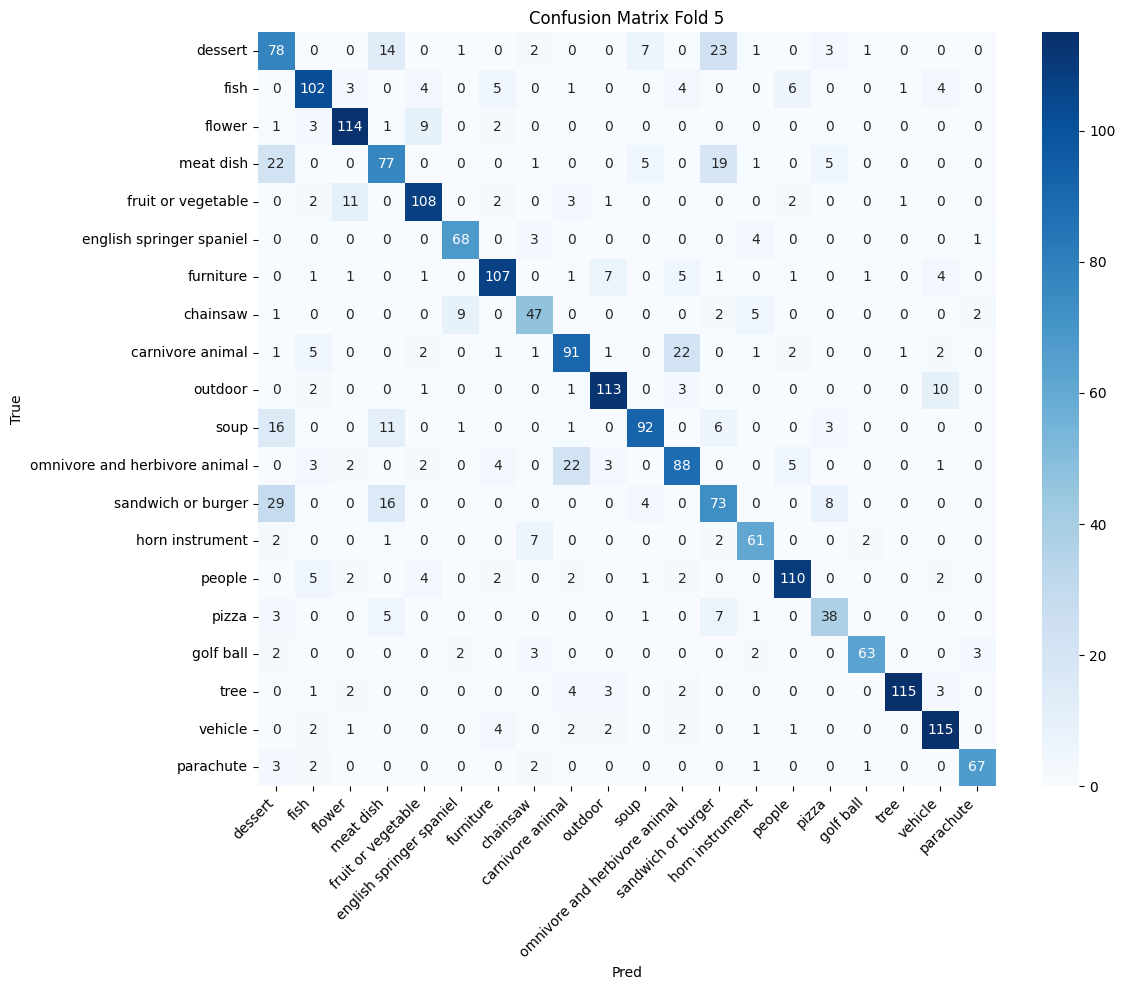

>>> Fold 6/10
Epoch 1/150 | Train Loss: 1.5857, F1: 0.3416 | Val Loss: 0.5676, F1: 0.4470
Epoch 2/150 | Train Loss: 1.1219, F1: 0.4694 | Val Loss: 0.4476, F1: 0.5286
Epoch 3/150 | Train Loss: 0.9264, F1: 0.5364 | Val Loss: 0.4243, F1: 0.5499
Epoch 4/150 | Train Loss: 0.7991, F1: 0.5866 | Val Loss: 0.4101, F1: 0.5819
Epoch 5/150 | Train Loss: 0.7136, F1: 0.6183 | Val Loss: 0.3547, F1: 0.6334
Epoch 6/150 | Train Loss: 0.6381, F1: 0.6488 | Val Loss: 0.3147, F1: 0.6573
Epoch 7/150 | Train Loss: 0.5909, F1: 0.6718 | Val Loss: 0.3137, F1: 0.6521
Epoch 8/150 | Train Loss: 0.5383, F1: 0.6929 | Val Loss: 0.2814, F1: 0.6886
Epoch 9/150 | Train Loss: 0.5052, F1: 0.7088 | Val Loss: 0.2707, F1: 0.6972
Epoch 10/150 | Train Loss: 0.4577, F1: 0.7297 | Val Loss: 0.2839, F1: 0.6969
Epoch 11/150 | Train Loss: 0.4328, F1: 0.7418 | Val Loss: 0.2558, F1: 0.7156
Epoch 12/150 | Train Loss: 0.4083, F1: 0.7540 | Val Loss: 0.2618, F1: 0.7135
Epoch 13/150 | Train Loss: 0.3716, F1: 0.7679 | Val Loss: 0.2756, F1: 0

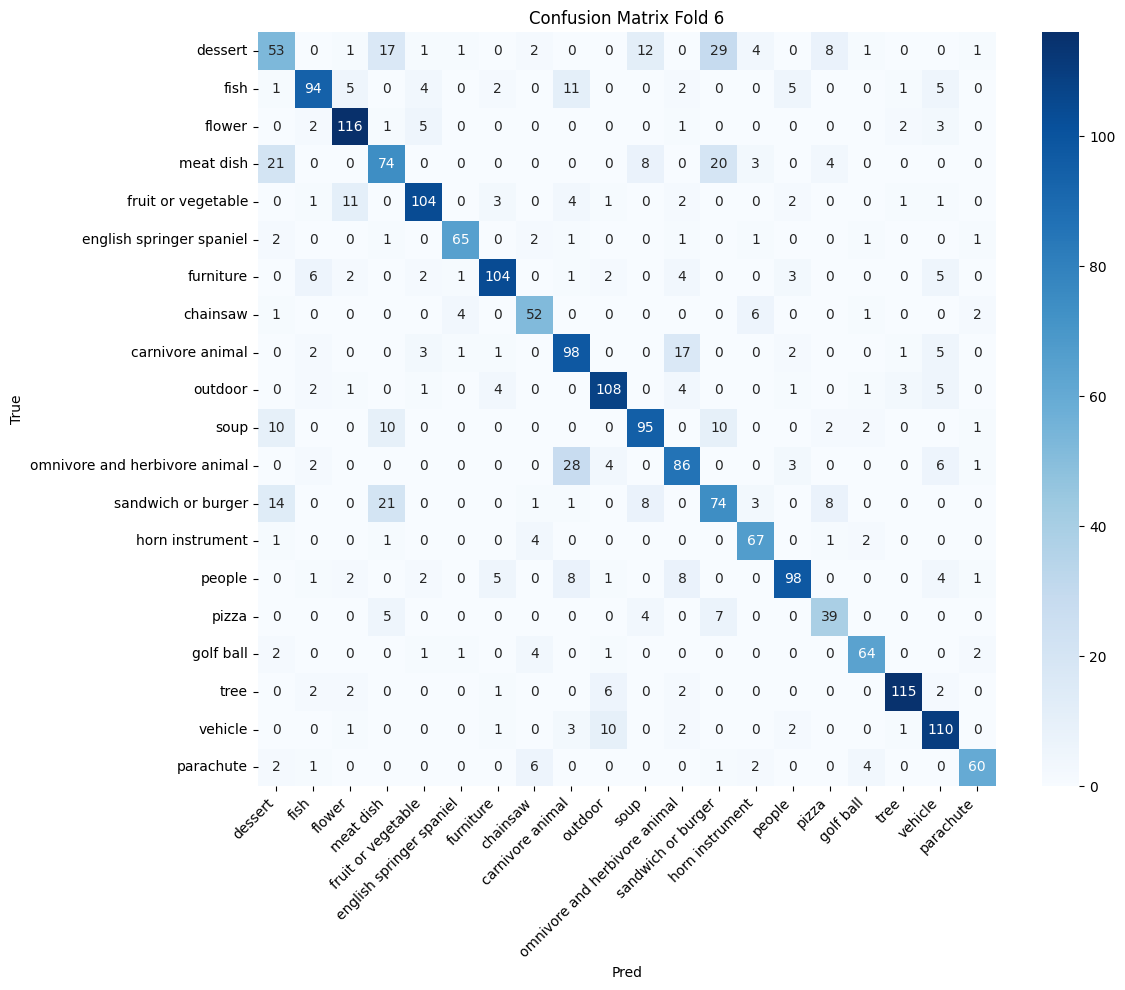

>>> Fold 7/10
Epoch 1/150 | Train Loss: 1.5906, F1: 0.3406 | Val Loss: 0.5864, F1: 0.4287
Epoch 2/150 | Train Loss: 1.1009, F1: 0.4743 | Val Loss: 0.4511, F1: 0.5473
Epoch 3/150 | Train Loss: 0.9317, F1: 0.5350 | Val Loss: 0.4119, F1: 0.5810
Epoch 4/150 | Train Loss: 0.8042, F1: 0.5822 | Val Loss: 0.4021, F1: 0.5910
Epoch 5/150 | Train Loss: 0.7296, F1: 0.6125 | Val Loss: 0.3474, F1: 0.6274
Epoch 6/150 | Train Loss: 0.6506, F1: 0.6439 | Val Loss: 0.3350, F1: 0.6325
Epoch 7/150 | Train Loss: 0.5992, F1: 0.6658 | Val Loss: 0.3001, F1: 0.6837
Epoch 8/150 | Train Loss: 0.5457, F1: 0.6910 | Val Loss: 0.2849, F1: 0.6799
Epoch 9/150 | Train Loss: 0.5079, F1: 0.7056 | Val Loss: 0.2863, F1: 0.6894
Epoch 10/150 | Train Loss: 0.4712, F1: 0.7241 | Val Loss: 0.2828, F1: 0.6820
Epoch 11/150 | Train Loss: 0.4439, F1: 0.7347 | Val Loss: 0.2742, F1: 0.6958
Epoch 12/150 | Train Loss: 0.4118, F1: 0.7494 | Val Loss: 0.2526, F1: 0.7107
Epoch 13/150 | Train Loss: 0.3869, F1: 0.7630 | Val Loss: 0.2767, F1: 0

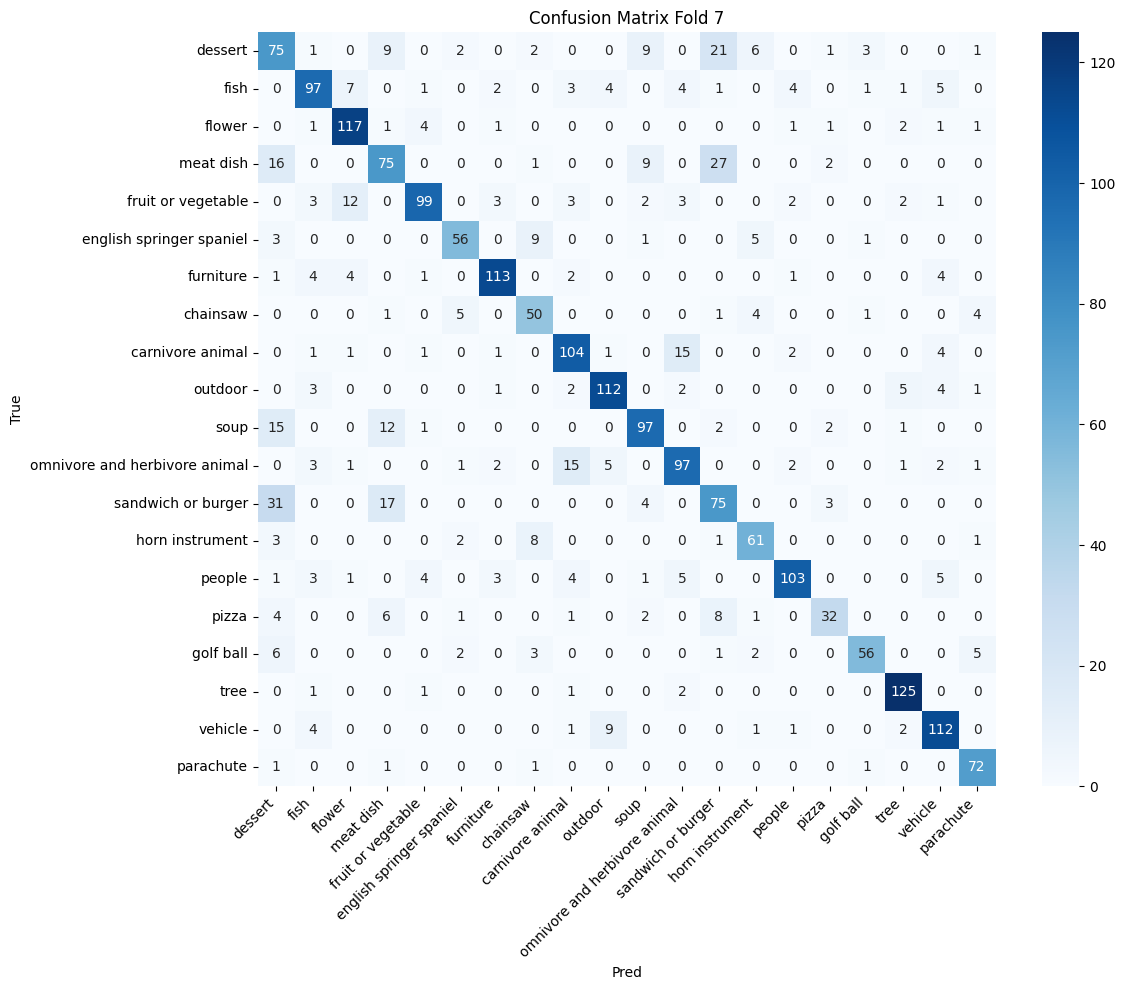

>>> Fold 8/10
Epoch 1/150 | Train Loss: 1.5842, F1: 0.3402 | Val Loss: 0.5872, F1: 0.4359
Epoch 2/150 | Train Loss: 1.1119, F1: 0.4713 | Val Loss: 0.4424, F1: 0.5617
Epoch 3/150 | Train Loss: 0.9144, F1: 0.5396 | Val Loss: 0.4079, F1: 0.5744
Epoch 4/150 | Train Loss: 0.8088, F1: 0.5834 | Val Loss: 0.3642, F1: 0.6066
Epoch 5/150 | Train Loss: 0.7179, F1: 0.6184 | Val Loss: 0.3504, F1: 0.6389
Epoch 6/150 | Train Loss: 0.6449, F1: 0.6476 | Val Loss: 0.3130, F1: 0.6570
Epoch 7/150 | Train Loss: 0.5893, F1: 0.6699 | Val Loss: 0.3046, F1: 0.6643
Epoch 8/150 | Train Loss: 0.5473, F1: 0.6917 | Val Loss: 0.2946, F1: 0.6787
Epoch 9/150 | Train Loss: 0.4979, F1: 0.7089 | Val Loss: 0.2932, F1: 0.6777
Epoch 10/150 | Train Loss: 0.4716, F1: 0.7230 | Val Loss: 0.2751, F1: 0.6965
Epoch 11/150 | Train Loss: 0.4376, F1: 0.7378 | Val Loss: 0.2642, F1: 0.7133
Epoch 12/150 | Train Loss: 0.4068, F1: 0.7544 | Val Loss: 0.2470, F1: 0.7272
Epoch 13/150 | Train Loss: 0.3775, F1: 0.7681 | Val Loss: 0.2429, F1: 0

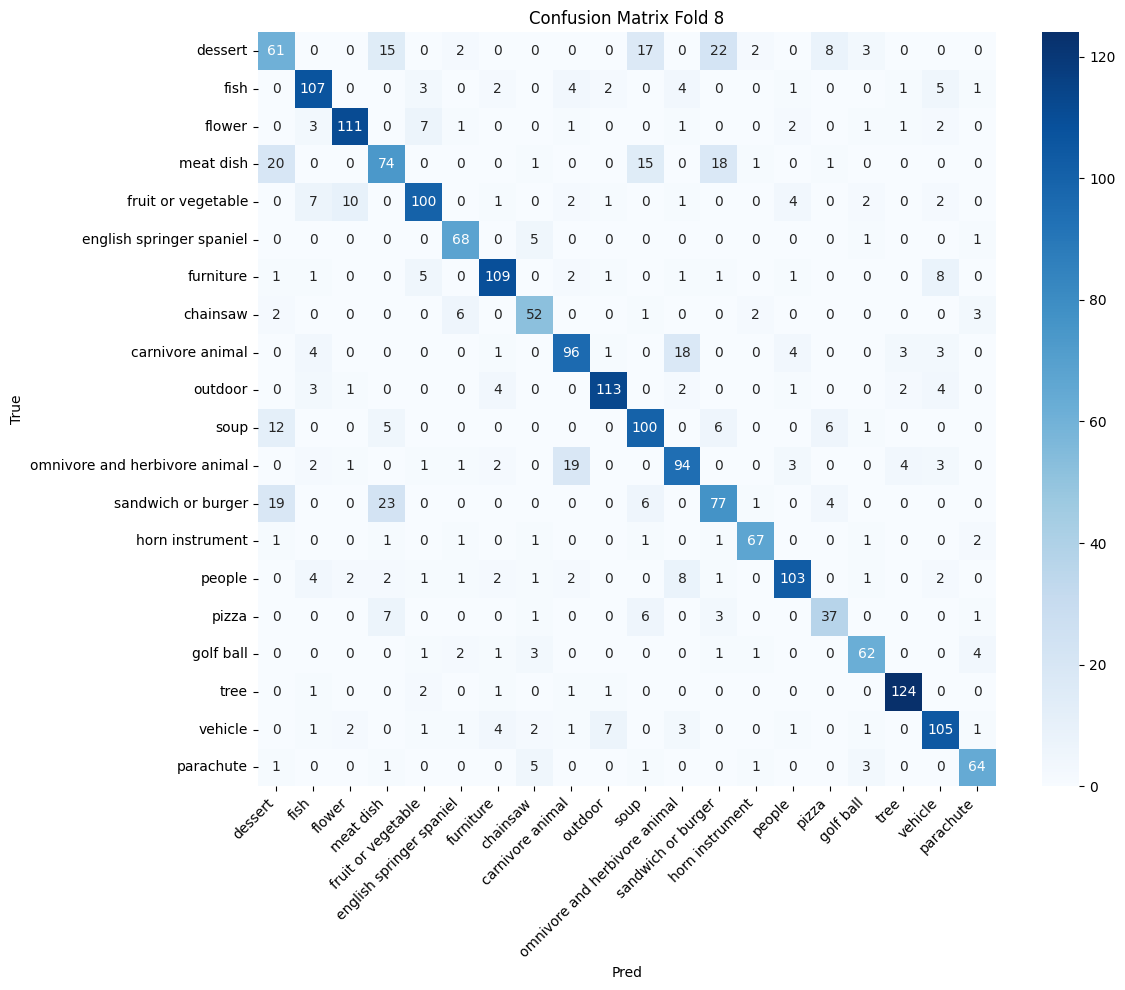

>>> Fold 9/10
Epoch 1/150 | Train Loss: 1.5948, F1: 0.3359 | Val Loss: 0.5964, F1: 0.4254
Epoch 2/150 | Train Loss: 1.1219, F1: 0.4694 | Val Loss: 0.4689, F1: 0.5176
Epoch 3/150 | Train Loss: 0.9236, F1: 0.5385 | Val Loss: 0.4236, F1: 0.5669
Epoch 4/150 | Train Loss: 0.8015, F1: 0.5854 | Val Loss: 0.3670, F1: 0.5993
Epoch 5/150 | Train Loss: 0.7018, F1: 0.6230 | Val Loss: 0.3463, F1: 0.6058
Epoch 6/150 | Train Loss: 0.6486, F1: 0.6468 | Val Loss: 0.3118, F1: 0.6513
Epoch 7/150 | Train Loss: 0.5898, F1: 0.6706 | Val Loss: 0.3096, F1: 0.6632
Epoch 8/150 | Train Loss: 0.5435, F1: 0.6926 | Val Loss: 0.2780, F1: 0.6995
Epoch 9/150 | Train Loss: 0.4992, F1: 0.7111 | Val Loss: 0.2728, F1: 0.6986
Epoch 10/150 | Train Loss: 0.4636, F1: 0.7259 | Val Loss: 0.2769, F1: 0.6921
Epoch 11/150 | Train Loss: 0.4371, F1: 0.7431 | Val Loss: 0.2714, F1: 0.6972
Epoch 12/150 | Train Loss: 0.4123, F1: 0.7535 | Val Loss: 0.2635, F1: 0.7019
Epoch 13/150 | Train Loss: 0.3781, F1: 0.7682 | Val Loss: 0.2504, F1: 0

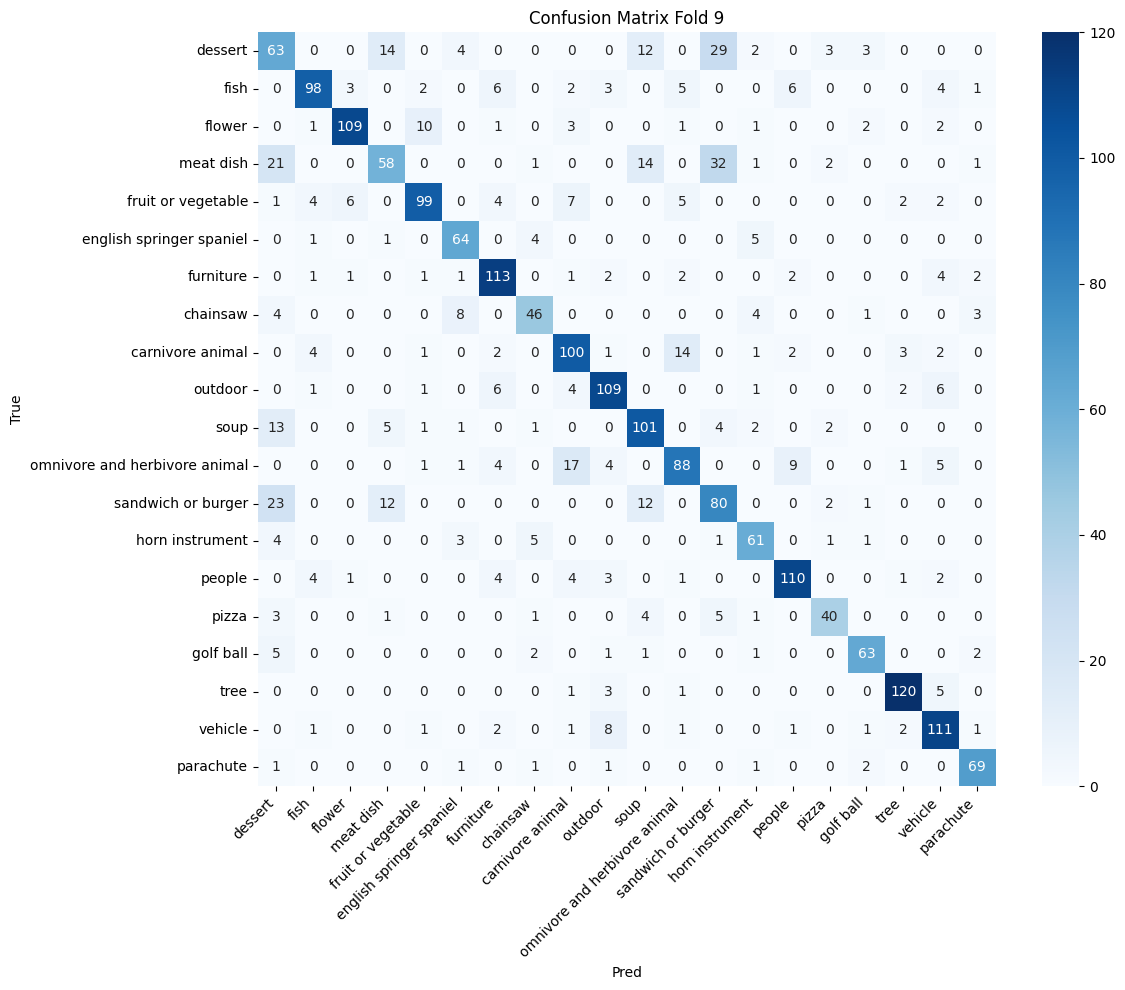

>>> Fold 10/10
Epoch 1/150 | Train Loss: 1.5576, F1: 0.3472 | Val Loss: 0.5352, F1: 0.4706
Epoch 2/150 | Train Loss: 1.0861, F1: 0.4796 | Val Loss: 0.4317, F1: 0.5413
Epoch 3/150 | Train Loss: 0.9168, F1: 0.5338 | Val Loss: 0.3857, F1: 0.5940
Epoch 4/150 | Train Loss: 0.7983, F1: 0.5824 | Val Loss: 0.3639, F1: 0.6133
Epoch 5/150 | Train Loss: 0.7144, F1: 0.6194 | Val Loss: 0.3449, F1: 0.6280
Epoch 6/150 | Train Loss: 0.6372, F1: 0.6512 | Val Loss: 0.3490, F1: 0.6384
Epoch 7/150 | Train Loss: 0.5826, F1: 0.6744 | Val Loss: 0.3024, F1: 0.6711
Epoch 8/150 | Train Loss: 0.5408, F1: 0.6914 | Val Loss: 0.2706, F1: 0.6911
Epoch 9/150 | Train Loss: 0.5005, F1: 0.7099 | Val Loss: 0.2795, F1: 0.6908
Epoch 10/150 | Train Loss: 0.4606, F1: 0.7273 | Val Loss: 0.2754, F1: 0.6940
Epoch 11/150 | Train Loss: 0.4222, F1: 0.7443 | Val Loss: 0.2526, F1: 0.7193
Epoch 12/150 | Train Loss: 0.3995, F1: 0.7549 | Val Loss: 0.2631, F1: 0.7086
Epoch 13/150 | Train Loss: 0.3731, F1: 0.7692 | Val Loss: 0.2560, F1: 

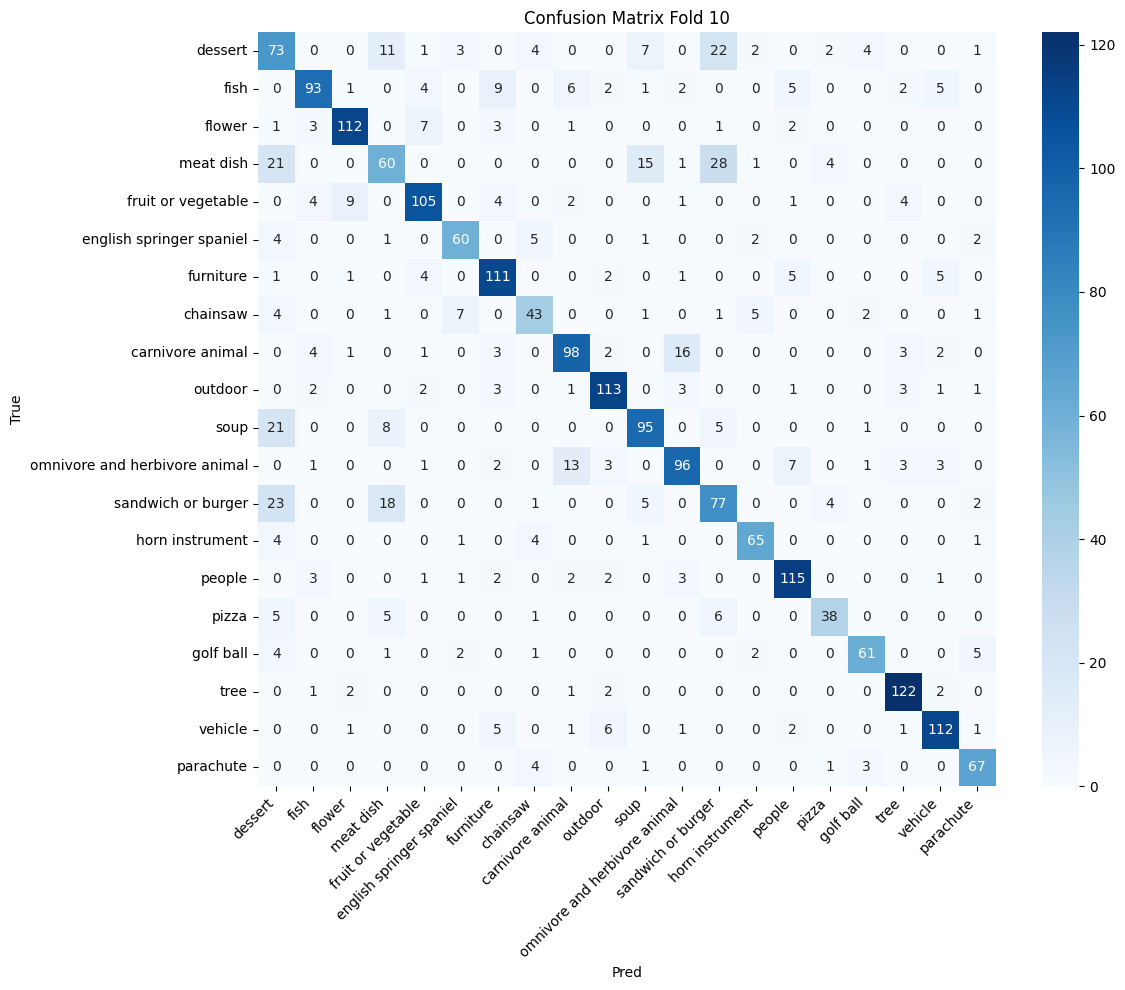

Params {'optimizer': 'sgd', 'learning_rate': 0.005, 'momentum': 0.95, 'weight_decay': 0.0001, 'dropout': 0.1, 'flip_prob': 0.5, 'rotation_degrees': 15, 'brightness': 0.1, 'contrast': 0.1, 'saturation': 0.1} -> Avg macro-F1: 0.7733

Best params: {'optimizer': 'sgd', 'learning_rate': 0.005, 'momentum': 0.95, 'weight_decay': 0.0001, 'dropout': 0.1, 'flip_prob': 0.5, 'rotation_degrees': 15, 'brightness': 0.1, 'contrast': 0.1, 'saturation': 0.1}
Best avg F1: 0.7732626807139721


In [8]:
import copy
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader, WeightedRandomSampler
from torchvision import transforms as T
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Definizione di Focal Loss corretta
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Focal Loss (Lin et al. 2017)
    alpha: bilanciamento di classe (float o lista di float di lunghezza n_class)
    gamma: parametro di focalizzazione (default=2.0)
    reduction: 'mean', 'sum' o 'none'
    """
    def __init__(self, alpha=1, gamma=2.0, reduction='mean'):
        super().__init__()
        if isinstance(alpha, (float, int)):
            self.alpha = torch.tensor([alpha], dtype=torch.float)
        else:
            self.alpha = torch.tensor(alpha, dtype=torch.float)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: logits (B, C), targets: class indices (B,)
        logpt = -F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(logpt)

        # sposta alpha sul device
        if self.alpha.device != inputs.device:
            self.alpha = self.alpha.to(inputs.device)

        # seleziona alpha per sample: se vettore, usa indicizzazione, altrimenti scalar
        if self.alpha.numel() > 1:
            at = self.alpha[targets]
        else:
            at = self.alpha

        # calcola focal loss
        loss = - at * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


def train_model(model, train_loader, val_loader, criterion, optimizer,
               scheduler=None, num_epochs=50, patience=5,
               device='cuda'):
    """
    Trains a model and performs validation con early stopping
    Returns best validation F1 score.
    """
    from sklearn.metrics import f1_score
    best_val_f1 = 0.0
    no_improve = 0
    best_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='macro')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}")

        if scheduler is not None:
            scheduler.step(val_f1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val F1: {best_val_f1:.4f}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val_f1


def hyperparameter_tuning(dataset, param_grid,
                          n_splits=5, batch_size=64, num_epochs=30,
                          patience=5, device='cuda'):
    """
    Hyperparameter tuning con k-fold cross-validation e Focal Loss.
    """
    # Estrai etichette
    if hasattr(dataset, 'targets'):
        labels = np.array(dataset.targets)
    else:
        labels = np.array([dataset[i][1] for i in range(len(dataset))])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    base_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.5132, 0.4647, 0.4044], std=[0.2626, 0.2559, 0.2748]),
    ])

    ensemble_models = []
    best_params, best_f1 = None, 0.0

    # Definizione dei nomi delle classi (necessario per confusion matrix)
    class_names = [
        "dessert", "fish", "flower", "meat dish", "fruit or vegetable",
        "english springer spaniel", "furniture", "chainsaw", "carnivore animal",
        "outdoor", "soup", "omnivore and herbivore animal", "sandwich or burger",
        "horn instrument", "people", "pizza", "golf ball",
        "tree", "vehicle", "parachute"
    ]

    for params in param_grid:
        print(f"\nTrying parameters: {params}")
        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
            print(f">>> Fold {fold}/{n_splits}")

            # Copie dataset e trasformazioni
            train_ds = copy.deepcopy(dataset)
            val_ds = copy.deepcopy(dataset)
            train_ds.transform = T.Compose([
                transforms.RandomVerticalFlip(p=0.2),
                transforms.Pad(padding=4, padding_mode='reflect'),
                transforms.RandomCrop(40),
                transforms.RandomRotation(degrees=15),
                T.ColorJitter(
                    brightness=params.get('brightness', 0.2),
                    contrast=params.get('contrast', 0.2),
                    saturation=params.get('saturation', 0.2)
                ),
                T.GaussianBlur(kernel_size=(3,3), sigma=(0.1,0.5)),
                T.ToTensor(),
                T.Normalize(mean=[0.5132, 0.4647, 0.4044], std=[0.2626, 0.2559, 0.2748]),
            ])
            val_ds.transform = base_transform

            train_subset = Subset(train_ds, train_idx)
            val_subset = Subset(val_ds, val_idx)

            # Weighted sampler
            fold_targets = labels[train_idx]
            class_counts = np.bincount(fold_targets)
            class_weights = 1.0 / class_counts
            sample_weights = class_weights[fold_targets]
            num_classes = len(class_counts)
            num_samples = (len(fold_targets) // num_classes) * num_classes
            sampler = WeightedRandomSampler(weights=sample_weights,
                                            num_samples=2*num_samples,
                                            replacement=True)

            train_loader = DataLoader(train_subset, batch_size=batch_size,
                                      sampler=sampler, num_workers=4, pin_memory=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size,
                                    shuffle=False, num_workers=4, pin_memory=True)

            # Modello
            model = ImageClassifier(num_classes=num_classes,
                                    dropout=params.get('dropout', 0.2)).to(device)

            # Focal Loss
            criterion = FocalLoss(alpha=0.5, gamma=2.0, reduction='mean')
            # -- oppure alpha vettoriale basato sulla distribuzione --
            #alpha_vec = 1.0 / class_counts
            #alpha_vec = alpha_vec / alpha_vec.sum()
            #criterion = FocalLoss(alpha=alpha_vec.tolist(), gamma=2.5, reduction='mean')

            # Ottimizzatore e scheduler
            if params.get('optimizer', 'adam') == 'sgd':
                optimizer = torch.optim.SGD(model.parameters(),
                                            lr=params.get('learning_rate', 0.001),
                                            momentum=params.get('momentum', 0.9),
                                            weight_decay=params.get('weight_decay', 0.0001))
            else:
                optimizer = torch.optim.Adam(model.parameters(),
                                             lr=params.get('learning_rate', 0.001),
                                             weight_decay=params.get('weight_decay', 0.0001))
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

            # Training
            best_f1_fold = train_model(model, train_loader, val_loader,
                                       criterion, optimizer, scheduler,
                                       num_epochs=num_epochs, patience=patience,
                                       device=device)
            
            fold_scores.append(best_f1_fold)

            # Valutazione
            model.eval()
            all_preds, all_targets = [], []
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
            
            ensemble_models.append(copy.deepcopy(model.cpu()))

            print(classification_report(all_targets, all_preds, digits=4))
            cm = confusion_matrix(all_targets, all_preds)
            plt.figure(figsize=(12,10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names)
            plt.title(f'Confusion Matrix Fold {fold}')
            plt.ylabel('True')
            plt.xlabel('Pred')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()


        avg_f1 = np.mean(fold_scores)
        print(f"Params {params} -> Avg macro-F1: {avg_f1:.4f}")
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_params = params

    print("\nBest params:", best_params)
    print("Best avg F1:", best_f1)
    return best_params, best_f1, ensemble_models

param_grid = [
    {'optimizer':'sgd', 'learning_rate':0.005, 'momentum':0.95,  'weight_decay':1e-4,
     'dropout':0.1, 'flip_prob':0.5, 'rotation_degrees':15,
     'brightness':0.1, 'contrast':0.1, 'saturation':0.1}
]

best_params, best_f1, ensemble_models = hyperparameter_tuning(train_dataset, param_grid,
                                   n_splits=10, batch_size=64, num_epochs=150,
                                   patience=5, device=device)


In [9]:
def train_final_model(dataset, best_params, batch_size=64, num_epochs=50, device='cuda'):
    """
    Allena il modello finale utilizzando i migliori parametri trovati durante il tuning.
    
    Args:
        dataset: Il dataset di addestramento completo
        best_params: I migliori parametri trovati con hyperparameter_tuning
        batch_size: Dimensione del batch
        num_epochs: Numero di epoche di addestramento
        device: Dispositivo su cui eseguire l'addestramento ('cuda' o 'cpu')
    
    Returns:
        Il modello addestrato
    """
    import torch
    import numpy as np
    from torch.utils.data import DataLoader, WeightedRandomSampler
    from torchvision import transforms as T
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    import copy
    
    # Estrai etichette per il weighted sampling
    if hasattr(dataset, 'targets'):
        labels = np.array(dataset.targets)
    else:
        labels = np.array([dataset[i][1] for i in range(len(dataset))])
    
    # Calcola i pesi per il sampling bilanciato
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels]
    num_classes = len(class_counts)
    
    # Prepara il dataset con le trasformazioni appropriate dai migliori parametri
    train_ds = copy.deepcopy(dataset)
    train_ds.transform = T.Compose([
        T.RandomHorizontalFlip(p=best_params.get('flip_prob', 0.5)),
        T.RandomRotation(best_params.get('rotation_degrees', 15)),
        T.ColorJitter(
            brightness=best_params.get('brightness', 0.2),
            contrast=best_params.get('contrast', 0.2),
            saturation=best_params.get('saturation', 0.2)
        ),
        T.ToTensor(),
        T.Normalize(mean=[0.5132, 0.4647, 0.4044], std=[0.2626, 0.2559, 0.2748]),
    ])
    
    # Crea weighted sampler per bilanciare le classi
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(labels),
        replacement=True
    )
    
    # Crea il dataloader
    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size,
        sampler=sampler, 
        num_workers=4, 
        pin_memory=True
    )
    
    # Inizializza il modello
    model = ImageClassifier(num_classes=num_classes, dropout=best_params.get('dropout', 0.2)).to(device)
    
    # Focal Loss come criterio di loss
    criterion = FocalLoss(alpha=0.25, gamma=2.0, reduction='mean')
    
    # Configura ottimizzatore in base ai migliori parametri
    if best_params.get('optimizer', 'adam') == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=best_params.get('learning_rate', 0.001),
            momentum=best_params.get('momentum', 0.9),
            weight_decay=best_params.get('weight_decay', 0.0001)
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=best_params.get('learning_rate', 0.001),
            weight_decay=best_params.get('weight_decay', 0.0001)
        )
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Addestramento completo
    from sklearn.metrics import f1_score
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='macro')
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, F1: {train_f1:.4f}")
        
        # Aggiorna lo scheduler
        scheduler.step(train_f1)
    
    print(f"Final model training completed with parameters: {best_params}")
    return model

In [10]:
def predict_with_ensemble(models, dataloader, device='cuda'):
    # 1) Prepara i modelli in eval e sulla GPU
    for m in models:
        m.to(device)
        m.eval()

    all_preds = []
    with torch.no_grad():
        for images, img_ids in dataloader:
            images = images.to(device)

            # 2) Raccogli i logits di tutti i modelli
            outputs = [m(images).cpu() for m in models]  # ognuno è (B, C)

            # 3) Media dei logits (o delle softmax)
            avg_logits = torch.stack(outputs, dim=0).mean(dim=0)  # (B, C)
            # avg_probs  = torch.stack([F.softmax(o, dim=1) for o in outputs], dim=0).mean(0)
            # preds = torch.argmax(avg_probs, dim=1)

            preds = torch.argmax(avg_logits, dim=1)

            # 4) Accumula (id, pred)
            all_preds.extend(zip(img_ids, preds.numpy()))

    return all_preds



#Output for kaggle
results = []
# rebuild loader here to avoid label‑expectations
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# Usa l'ensemble
results = predict_with_ensemble(ensemble_models, test_loader, device=device)

# Salva su CSV
submission_df = pd.DataFrame(results, columns=['id', 'label'])
submission_df.to_csv('submission.csv', index=False)
print(f"Saved {len(submission_df)} predictions to submission.csv")

Saved 4000 predictions to submission.csv
